## Resources link

https://www.youtube.com/watch?v=l16RxAmP9QE&list=PLdxQ7SoCLQAMeMPpRvqXJjBSmKey0SdlH

http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/

http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/


In [58]:
from keras.datasets import mnist

In [59]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()


In [60]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [61]:
# The mnist package handles the MNIST dataset for us!
# Learn more at https://github.com/datapythonista/mnist
train_images = train_X
train_labels = train_y

## Convolutional Neural Networks
CNNs were responsible for major breakthroughs in Image Classification and are the core of most Computer Vision systems 

## What is Convolution?
The for me easiest way to understand a convolution is by thinking of it as a sliding window function applied to a matrix. That’s a mouthful, but it becomes quite clear looking at a visualization:

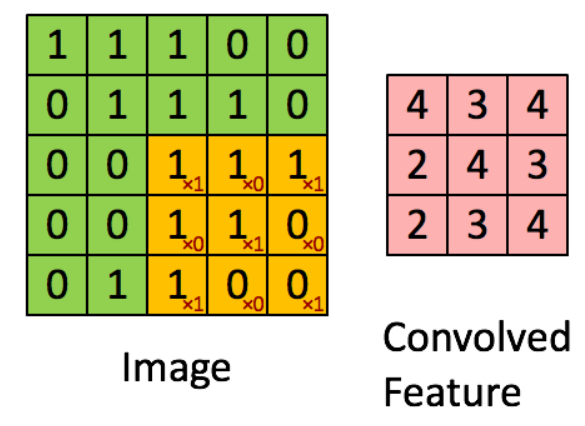

Imagine that the matrix on the left represents an black and white image. Each entry corresponds to one pixel, 0 for black and 1 for white (typically it’s between 0 and 255 for grayscale images). The sliding window is called a kernel, filter, or feature detector. Here we use a 3×3 filter, multiply its values element-wise with the original matrix, then sum them up. To get the full convolution we do this for each element by sliding the filter over the whole matrix.

In [62]:
import numpy as np

class Conv:
  # A Convolution layer using filters_lengthxfilters_length filters.

  def __init__(self, num_filters, filters_length):
    self.num_filters = num_filters
    self.filters_length = filters_length
    # filters is a 3d array with dimensions (num_filters, filters_length, filters_length)
    # We divide by filters_length*filters_length to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, filters_length, filters_length) / (filters_length* filters_length)
    
  def iterate_regions(self, image):
    '''
    Generates all possible filters_length x filters_length image regions using valid padding.
    - image is a 2d numpy array
    '''
    h, w = image.shape

    for i in range(h - (self.filters_length-1)):
      for j in range(w - (self.filters_length-1)):
        im_region = image[i:(i + self.filters_length), j:(j + self.filters_length)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input
    h, w = input.shape
    output = np.zeros((h - (self.filters_length-1), w - (self.filters_length-1), self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv3x3 as
    # the first layer in our CNN. Otherwise, we'd need to return
    # the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
    return None



## Pooling layers
Pooling layers subsample their input. The most common way to do pooling it to apply a max operation to the result of each filter. You don’t necessarily need to pool over the complete matrix, you could also pool over a window. For example, the following shows max pooling for a 2×2 window 
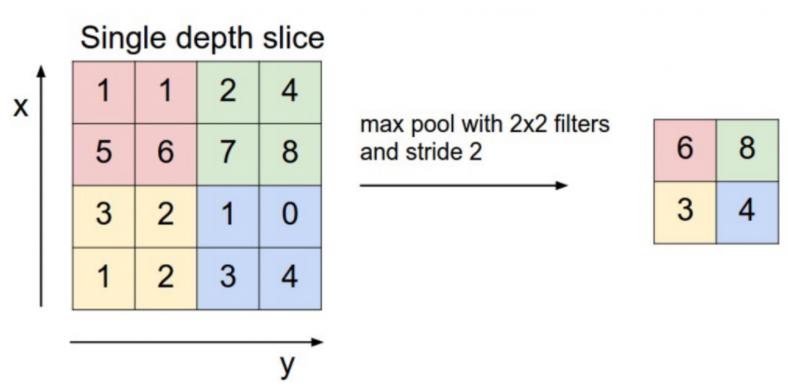

In [63]:
class MaxPool:
  # A Max Pooling layer using a pool size of Pool_length.

  def __init__(self, Pool_length):
    self.Pool_length = Pool_length

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
      '''

    h, w, _ = image.shape
    new_h = h // self.Pool_length
    new_w = w // self.Pool_length

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

    

  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input
    h, w, num_filters = input.shape
    output = np.zeros((h // self.Pool_length, w // self.Pool_length, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
          h, w, f = im_region.shape
          amax = np.amax(im_region, axis=(0, 1))

          for i2 in range(h):
            for j2 in range(w):
              for f2 in range(f):
                # If this pixel was the max value, copy the gradient to it.
                if im_region[i2, j2, f2] == amax[f2]:
                  d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

In [64]:
import mnist

conv = Conv(8,3)
output = conv.forward(train_images[0])
print(output.shape) # (26, 26, 8)


(26, 26, 8)


In [65]:
conv = Conv(8,3)
pool = MaxPool(2)

output = conv.forward(train_images[0])
output = pool.forward(output)
print(output.shape) # (13, 13, 8)

(13, 13, 8)


## Softmax
The Sigmoid Activation function we have used earlier for binary classification needs to be changed for multi-class classification. The basic idea of Softmax is to distribute the probability of different classes so that they sum to 1. Earlier we have used only one Sigmoid hidden unit, now the number of Softmax hidden units needs to be same as the number of classes. Since we will be using the full MNIST dataset here, we have total 10 classes, hence we need 10 hidden units at the final layer of our Network. The Softmax Activation function looks at all the Z values from all (10 here) hidden unit and provides the probability for the each class. Later during prediction we can just take the most probable one and assume that’s that final output.

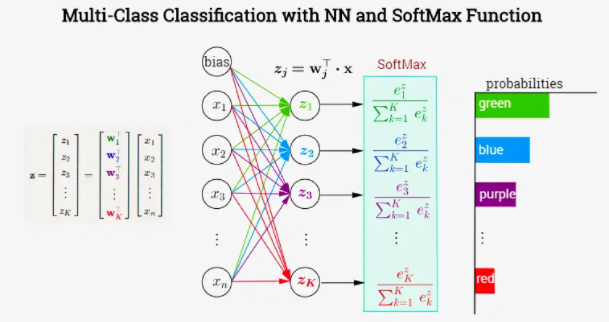

## Loss Function
We will be using the Cross-Entropy Loss (in log scale) with the SoftMax, which can be defined as,

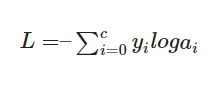

In [48]:
import numpy as np

class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)


  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b
      return d_L_d_inputs.reshape(self.last_input_shape)



In [ ]:
import mnist
import numpy as np

# We only use the first 1k testing examples (out of 10k total)
# in the interest of time. Feel free to change this if you want.
test_images = train_X[:1000]
test_labels = train_y[:1000]

conv = Conv(8,3)                  # 28x28x1 -> 26x26x8
pool = MaxPool(2)                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10) # 13x13x8 -> 10

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i > 0 and i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.182 | Accuracy: 24%
[Step 200] Past 100 steps: Average Loss 2.040 | Accuracy: 30%
[Step 300] Past 100 steps: Average Loss 1.576 | Accuracy: 49%
[Step 400] Past 100 steps: Average Loss 1.227 | Accuracy: 57%
[Step 500] Past 100 steps: Average Loss 1.017 | Accuracy: 63%
[Step 600] Past 100 steps: Average Loss 0.637 | Accuracy: 84%
[Step 700] Past 100 steps: Average Loss 0.728 | Accuracy: 79%
[Step 800] Past 100 steps: Average Loss 0.794 | Accuracy: 68%
[Step 900] Past 100 steps: Average Loss 0.780 | Accuracy: 74%
[Step 1000] Past 100 steps: Average Loss 0.518 | Accuracy: 80%
[Step 1100] Past 100 steps: Average Loss 0.634 | Accuracy: 76%
[Step 1200] Past 100 steps: Average Loss 0.566 | Accuracy: 82%
[Step 1300] Past 100 steps: Average Loss 0.811 | Accuracy: 71%
[Step 1400] Past 100 steps: Average Loss 0.532 | Accuracy: 84%
[Step 1500] Past 100 steps: Average Loss 0.370 | Accuracy: 91%
[Step 1600] Past 100 step